In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import re
from random import randint

In [9]:
# URL de búsqueda de laptops en mercadolibre.com.co
url_base = 'https://listado.mercadolibre.com.co'
busqueda = 'computadores-portatiles'  # Término más específico en español

# Realizar una solicitud GET a la URL de búsqueda
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept-Language': 'es-CO,es;q=0.9',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Connection': 'keep-alive',
    'Referer': 'https://www.mercadolibre.com.co/'
}
# Lista para almacenar información de laptops
laptop_list = []

In [ ]:
# Intentar con múltiples páginas
for page in range(1, 3):  # Limitamos a 2 páginas para evitar bloqueos
    if page == 1:
        url = f'{url_base}/{busqueda}'
    else:
        url = f'{url_base}/{busqueda}_Desde_{(page-1)*48 + 1}'
    
    print(f"Obteniendo página {page}: {url}")
    
    try:
        # Añadir un retraso aleatorio para simular comportamiento humano
        time.sleep(randint(2, 5))
        
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        # Guardar el HTML para depuración
        with open(f'pagina_{page}.html', 'w', encoding='utf-8') as f:
            f.write(response.text)
        print(f"HTML guardado en pagina_{page}.html para depuración")
        
        # Crear un objeto BeautifulSoup a partir de la respuesta
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Probar diferentes selectores que podrían funcionar con la estructura actual
        # Selector 1: Intentar con la clase ui-search-layout__item
        laptops = soup.select('li.ui-search-layout__item')
        
        if not laptops:
            # Selector 2: Intentar con otro selector común en Mercado Libre
            laptops = soup.select('div.ui-search-result')
        
        if not laptops:
            # Selector 3: Intentar con otro selector más general
            laptops = soup.select('div[class*="ui-search-result"]')
            
        if not laptops:
            # Selector 4: Intentar con otro selector aún más general
            laptops = soup.select('div.ui-search-result__wrapper')
        
        print(f"Se encontraron {len(laptops)} resultados en la página {page}")
        
        # Si no se encontraron resultados, imprimir parte del HTML para depuración
        if not laptops:
            print("No se encontraron resultados. Mostrando parte del HTML:")
            print(soup.prettify()[:1000])  # Mostrar los primeros 1000 caracteres
        
        # Recorrer cada laptop encontrada
        for laptop in laptops:
            try:
                # Imprimir la estructura HTML del primer elemento para depuración
                if laptop == laptops[0]:
                    print("Estructura del primer elemento:")
                    print(laptop.prettify()[:500])
                
                # Intentar diferentes selectores para el título
                # AQUÍ DEBES MODIFICAR: Selectores para el título
                title_element = laptop.select_one('h3.poly-component__title-wrapper a.poly-component__title')
                if not title_element:
                    title_element = laptop.select_one('h2.shops__item-title')
                if not title_element:
                    title_element = laptop.select_one('h2[class*="ui-search"]')
                
                title = title_element.text.strip() if title_element else 'Sin título'
                
                # Intentar diferentes selectores para el precio
                # AQUÍ DEBES MODIFICAR: Selectores para el precio
                price_element = laptop.select_one('span.andes-money-amount__fraction')
                if not price_element:
                    price_element = laptop.select_one('span.price-tag-fraction')
                if not price_element:
                    price_element = laptop.select_one('span[class*="price-tag-fraction"]')
                
                price_text = price_element.text.strip().replace(".", "") if price_element else '0'
                price = float(price_text) if price_text.isdigit() else 0
                
                # Intentar diferentes selectores para la ubicación
                # AQUÍ DEBES MODIFICAR: Selectores para la ubicación
                location_element = laptop.select_one('span.ui-search-item__location')
                if not location_element:
                    location_element = laptop.select_one('p.ui-search-item__location')
                if not location_element:
                    location_element = laptop.select_one('span[class*="ui-search-item__location"]')
                if not location_element:
                    location_element = laptop.select_one('p[class*="ui-search-item__location"]')
                
                location = location_element.text.strip() if location_element else 'Sin ubicación'
                
                # Intentar extraer marca del título
                # AQUÍ DEBES MODIFICAR: Extracción de marca
                brand = 'Desconocida'
                for known_brand in ['HP', 'Dell', 'Lenovo', 'Asus', 'Acer', 'Apple', 'MSI', 'Samsung', 'Huawei', 'Toshiba', 'Microsoft', 'LG', 'Gigabyte', 'Razer']:
                    if known_brand.lower() in title.lower():
                        brand = known_brand
                        break
                
                # Extraer RAM si está disponible en el título
                ram_match = re.search(r'(\d+)\s*[Gg][Bb](\s*[Rr][Aa][Mm]|\s*[Mm][Ee][Mm]|\s*[Dd][Ee]\s*[Rr][Aa][Mm])?', title)
                ram = ram_match.group(1) if ram_match else 'No especificado'
                
                # Extraer procesador si está disponible en el título
                processor = 'No especificado'
                for proc in ['Intel', 'i3', 'i5', 'i7', 'i9', 'Ryzen', 'AMD', 'M1', 'M2', 'M3', 'Snapdragon']:
                    if proc.lower() in title.lower():
                        processor_match = re.search(r'(Intel|Core\s+i\d|i\d|Ryzen|AMD|M\d|Snapdragon)[\s\-]?(\d+)?', title, re.IGNORECASE)
                        if processor_match:
                            processor = processor_match.group(0)
                            break
                
                # Extraer almacenamiento si está disponible en el título
                storage_match = re.search(r'(\d+)\s*[Gg][Bb]?\s*[Ss][Ss][Dd]|(\d+)\s*[Tt][Bb]\s*[Ss][Ss][Dd]?|(\d+)\s*[Tt][Bb]|(\d+)\s*[Gg][Bb]\s*[Hh][Dd][Dd]?', title)
                storage = storage_match.group(0) if storage_match else 'No especificado'
                
                # Agregar la información de la laptop a la lista
                laptop_list.append({
                    'title': title,
                    'price': price,
                    'location': location,
                    'brand': brand,
                    'ram': ram,
                    'processor': processor,
                    'storage': storage
                })
                
                # Imprimir información para depuración
                print(f"Laptop extraída: {title[:50]}... | Precio: {price} | Ubicación: {location}")
                
            except Exception as e:
                print(f"Error al procesar un elemento: {e}")
                continue
    
    except Exception as e:
        print(f"Error al obtener la página {page}: {e}")
        continue

Obteniendo página 1: https://listado.mercadolibre.com.co/computadores-portatiles


HTML guardado en pagina_1.html para depuración
Se encontraron 52 resultados en la página 1
Estructura del primer elemento:
<li class="ui-search-layout__item">
 <div style="display:contents">
  <div class="ui-search-result__wrapper">
   <div class="poly-card poly-card--list poly-card--large poly-card--CORE">
    <div class="poly-card__portada">
     <img alt="Computador Portatil Laptop Corporativo Promocion Usado" aria-hidden="true" class="poly-component__picture" decoding="sync" fetchpriority="high" height="150" src="https://http2.mlstatic.com/D_Q_NP_2X_762946-MCO83338686127_032025-V.webp" title="Computador Portatil
Laptop extraída: Computador Portatil Laptop Corporativo Promocion U... | Precio: 999999.0 | Ubicación: Sin ubicación
Laptop extraída: Pc Portátil Lenovo T14 Core I5 10ma - 512ssd - 16g... | Precio: 2390000.0 | Ubicación: Sin ubicación
Laptop extraída: Computador Portatil Dell 3520 Core I3 1215u 16gb 5... | Precio: 2257000.0 | Ubicación: Sin ubicación
Laptop extraída: Comput

In [ ]:
# Verificar si se obtuvieron datos
if not laptop_list:
    print("No se pudieron obtener datos. Intentando con una URL alternativa...")
    
    # Intentar con una URL alternativa
    url_alt = "https://listado.mercadolibre.com.co/computadores/portatiles/"
    
    try:
        response = requests.get(url_alt, headers=headers)
        
        # Guardar el HTML para depuración
        with open('url_alternativa.html', 'w', encoding='utf-8') as f:
            f.write(response.text)
        print("HTML de URL alternativa guardado para depuración")
        
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Intentar con diferentes selectores
        laptops = soup.select('div.ui-search-result')
        
        if not laptops:
            laptops = soup.select('li[class*="ui-search-layout__item"]')
            
        if not laptops:
            laptops = soup.select('div.ui-search-result__wrapper')
        
        print(f"Se encontraron {len(laptops)} resultados con URL alternativa")
    except Exception as e:
        print(f"Error con URL alternativa: {e}")

In [12]:
# Si aún no hay datos, crear algunos datos de ejemplo para demostración
if not laptop_list:
    print("No se pudieron obtener datos reales. Creando datos de ejemplo para demostración...")
    
    # Crear datos de ejemplo
    laptop_list = [
        {'title': 'Portátil HP Pavilion 15.6" Intel Core i5 8GB RAM 512GB SSD', 'price': 2499900, 'location': 'Bogotá D.C.', 'brand': 'HP', 'ram': '8', 'processor': 'Intel i5', 'storage': '512GB SSD'},
        
    ]

In [13]:
# Crear un DataFrame con la información de las laptops
df = pd.DataFrame(laptop_list)

# Convertir RAM a numérico para análisis
df['ram_num'] = pd.to_numeric(df['ram'], errors='coerce')

# Mostrar información básica del DataFrame
print("\nInformación del DataFrame:")
print(df.info())

print("\nEstadísticas descriptivas:")
print(df.describe())

print("\nPrimeras 5 filas del DataFrame:")
print(df.head())


Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      102 non-null    object 
 1   price      102 non-null    float64
 2   location   102 non-null    object 
 3   brand      102 non-null    object 
 4   ram        102 non-null    object 
 5   processor  102 non-null    object 
 6   storage    102 non-null    object 
 7   ram_num    99 non-null     float64
dtypes: float64(2), object(6)
memory usage: 6.5+ KB
None

Estadísticas descriptivas:
              price     ram_num
count  1.020000e+02   99.000000
mean   3.442737e+06   62.060606
std    2.119550e+06  124.608597
min    9.999990e+05    8.000000
25%    1.949900e+06   16.000000
50%    2.500000e+06   16.000000
75%    5.755691e+06   32.000000
max    8.116999e+06  512.000000

Primeras 5 filas del DataFrame:
                                               title      pric

In [ ]:
# muestrar los primeros 5 registros
df.head()

,title,price,location,brand,ram,processor,storage,ram_num,storage_num,storage_type,storage_label
0,Computador Portatil Laptop Corporativo Promoci...,999999.0,Sin ubicación,Desconocida,No especificado,No especificado,No especificado,NaN,NaN,No,nanNO
1,Pc Portátil Lenovo T14 Core I5 10ma - 512ssd -...,2390000.0,Sin ubicación,Lenovo,16,Core I5 10,No especificado,16.0,NaN,No,nanNO
2,Computador Portatil Dell 3520 Core I3 1215u 16...,2257000.0,Sin ubicación,Dell,16,Core I3 1215,No especificado,16.0,NaN,No,nanNO
3,Computador Portatil Gamer Lenovo Loq 15arp9 Gr...,5870588.0,Sin ubicación,Lenovo,16,Amd,512gb Ssd,16.0,512.0,gb,512.0GB
4,Computador Portatil Asus X1504za-nj227 Core I5...,1999900.0,Sin ubicación,Asus,24,Core I5 24,No especificado,24.0,NaN,No,nanNO


In [14]:
# Configuración para visualizaciones más atractivas
plt.style.use('ggplot')
sns.set_palette('Set2')

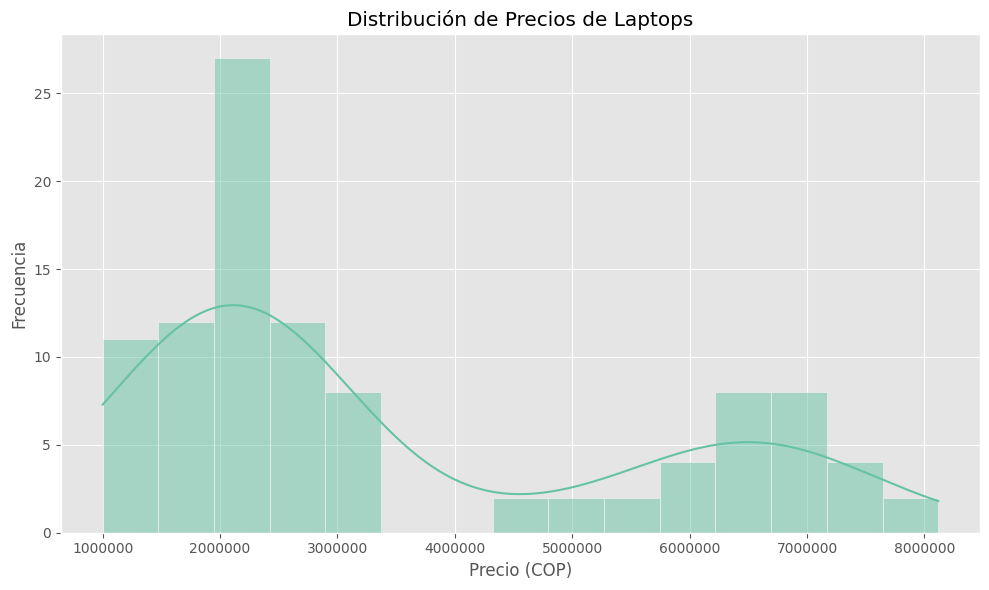

In [15]:
# 1. Gráfica de distribución de precios
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=15, kde=True)
plt.title('Distribución de Precios de Laptops')
plt.xlabel('Precio (COP)')
plt.ylabel('Frecuencia')
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()
plt.show()
plt.close()

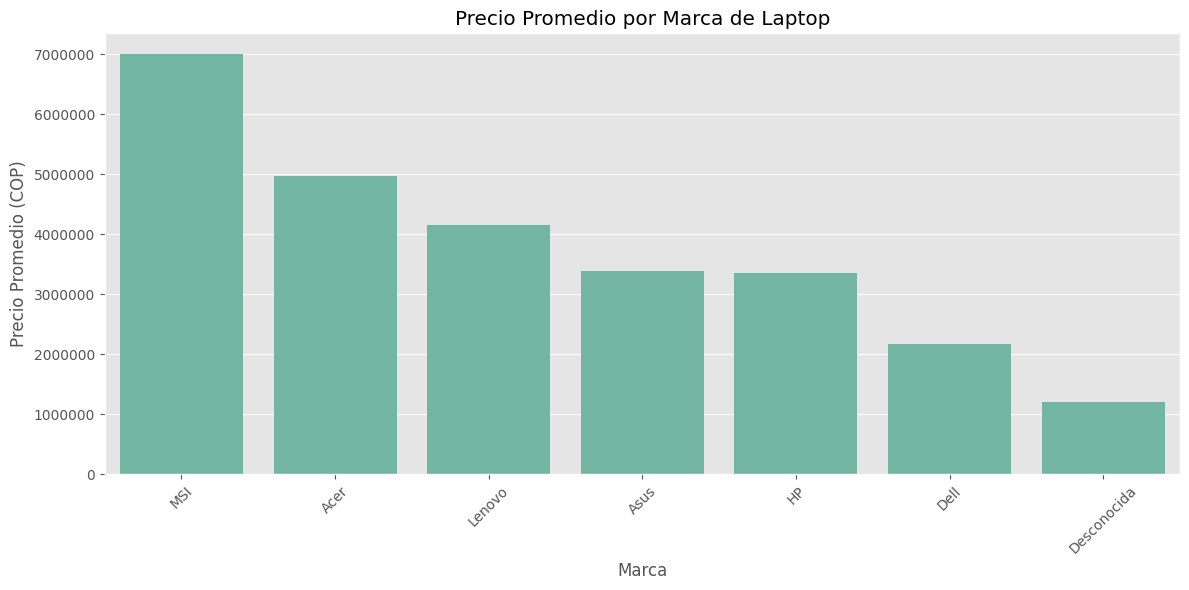

In [16]:
# 2. Gráfica de precio promedio por marca
plt.figure(figsize=(12, 6))
brand_avg = df.groupby('brand')['price'].mean().sort_values(ascending=False)
sns.barplot(x=brand_avg.index, y=brand_avg.values)
plt.title('Precio Promedio por Marca de Laptop')
plt.xlabel('Marca')
plt.ylabel('Precio Promedio (COP)')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()
plt.close()

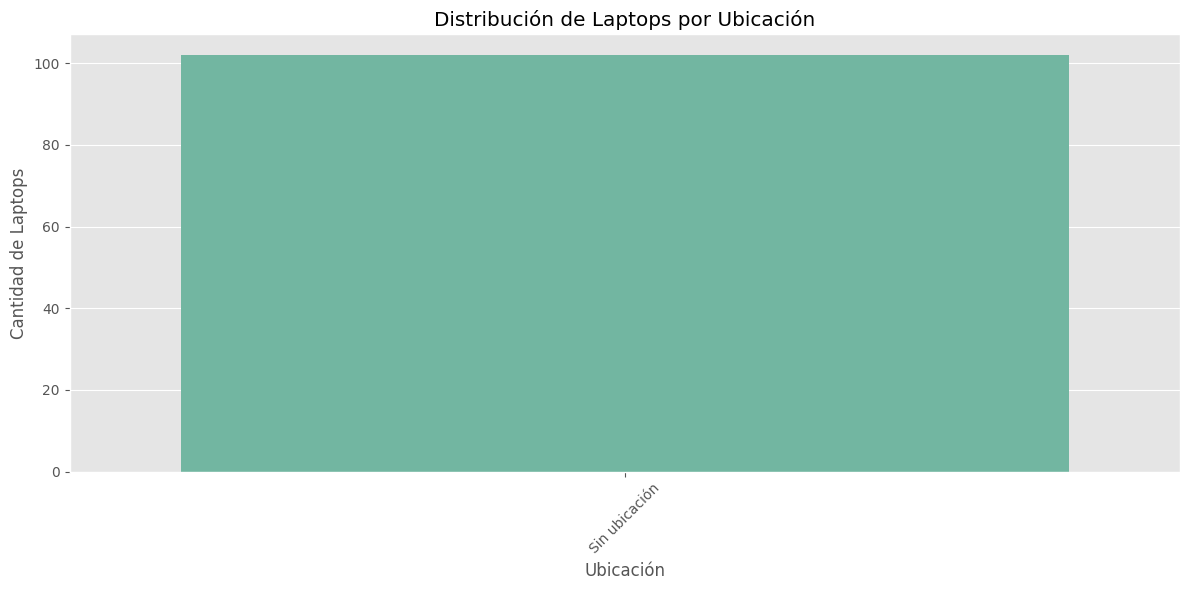

In [17]:
# 3. Gráfica de distribución de laptops por ubicación
plt.figure(figsize=(12, 6))
location_count = df['location'].value_counts()
sns.barplot(x=location_count.index, y=location_count.values)
plt.title('Distribución de Laptops por Ubicación')
plt.xlabel('Ubicación')
plt.ylabel('Cantidad de Laptops')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()

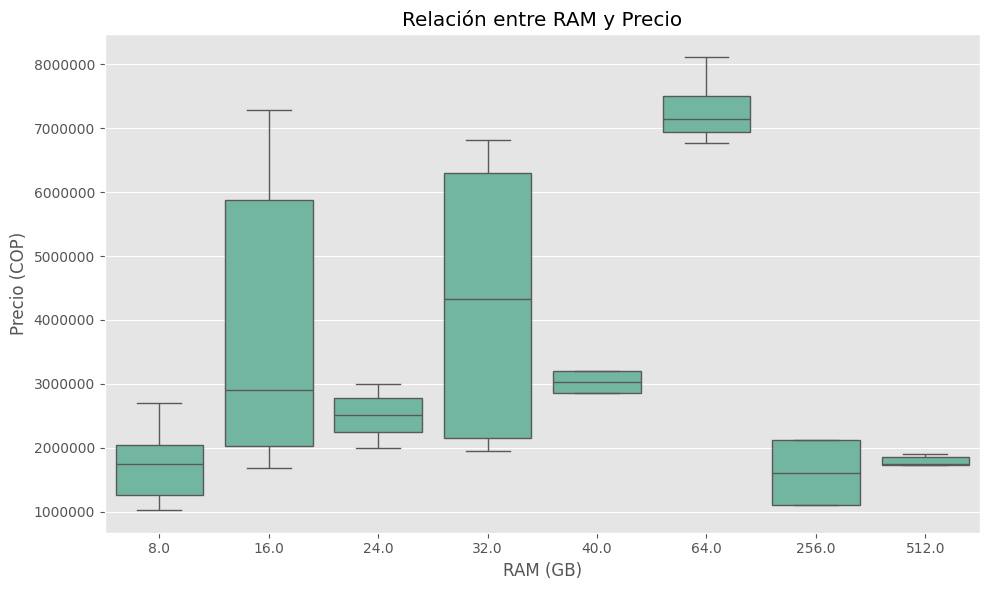

In [18]:
# 4. Gráfica de relación entre RAM y precio
plt.figure(figsize=(10, 6))
# Verificar si hay datos válidos en ram_num
if df['ram_num'].notna().any():
    sns.boxplot(x='ram_num', y='price', data=df)
    plt.title('Relación entre RAM y Precio')
    plt.xlabel('RAM (GB)')
    plt.ylabel('Precio (COP)')
    plt.ticklabel_format(style='plain', axis='y')
else:
    # Si no hay datos válidos, crear un gráfico alternativo
    plt.text(0.5, 0.5, 'No hay datos válidos de RAM para crear el boxplot', 
             horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.title('Relación entre RAM y Precio (No disponible)')
plt.tight_layout()
plt.show()
plt.close()

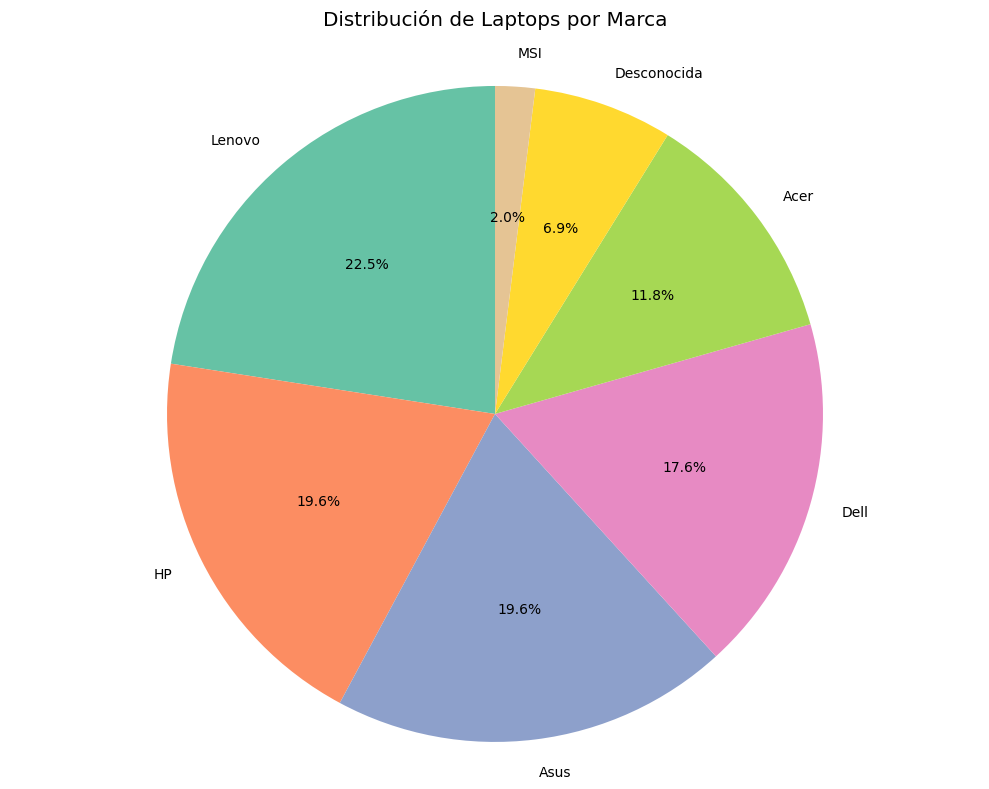

In [23]:
# 5. Gráfica de pastel para distribución de marcas
plt.figure(figsize=(10, 8))
brand_counts = df['brand'].value_counts()
plt.pie(brand_counts, labels=brand_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribución de Laptops por Marca', pad=20)
plt.tight_layout()
plt.show()
plt.close()

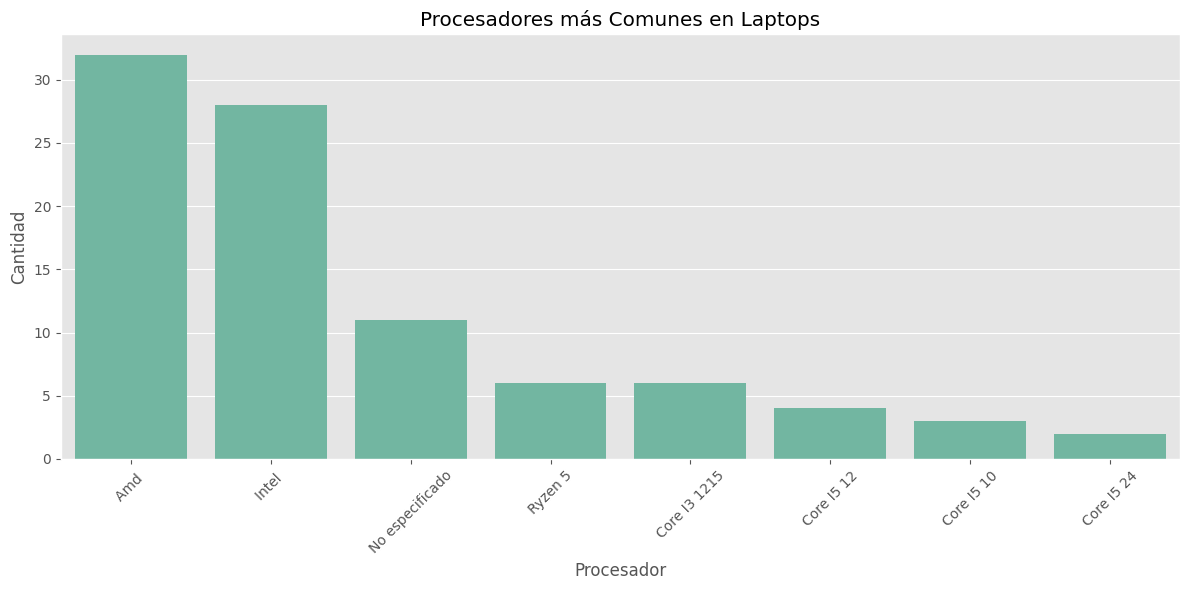

In [20]:
# 6. Gráfica de barras para procesadores
plt.figure(figsize=(12, 6))
processor_count = df['processor'].value_counts().head(8)  # Top 8 procesadores
sns.barplot(x=processor_count.index, y=processor_count.values)
plt.title('Procesadores más Comunes en Laptops')
plt.xlabel('Procesador')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()

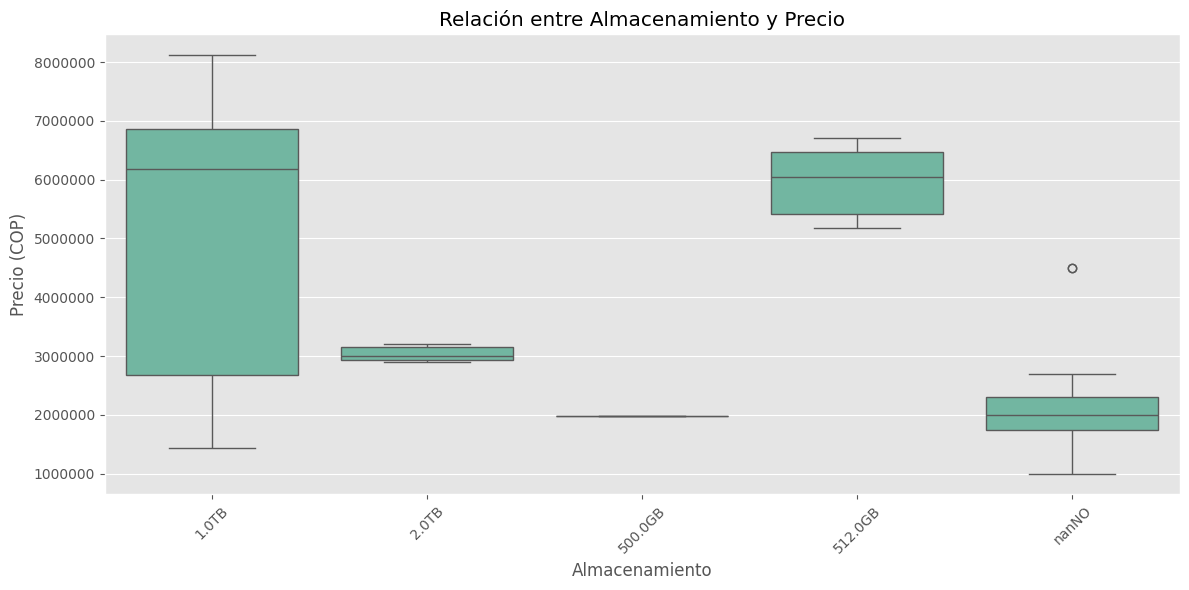

In [ ]:
# 7. Relación entre almacenamiento y precio
plt.figure(figsize=(12, 6))
# Extraer solo el número de GB/TB para ordenar correctamente
df['storage_num'] = df['storage'].str.extract(r'(\d+)').astype(float)
df['storage_type'] = df['storage'].str.extract(r'([A-Za-z]+)')

# Verificar si hay datos válidos
if 'storage_num' in df.columns and df['storage_num'].notna().any():
    # Crear una columna combinada para el gráfico
    df['storage_label'] = df['storage_num'].astype(str) + df['storage_type'].str.upper()
    
    # Ordenar por tamaño de almacenamiento
    storage_order = df.groupby('storage_label')['storage_num'].mean().sort_values().index
    
    sns.boxplot(x='storage_label', y='price', data=df, order=storage_order)
    plt.title('Relación entre Almacenamiento y Precio')
    plt.xlabel('Almacenamiento')
    plt.ylabel('Precio (COP)')
    plt.ticklabel_format(style='plain', axis='y')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'No hay datos válidos de almacenamiento para crear el boxplot', 
             horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.title('Relación entre Almacenamiento y Precio (No disponible)')
plt.tight_layout()
plt.show()
plt.close()

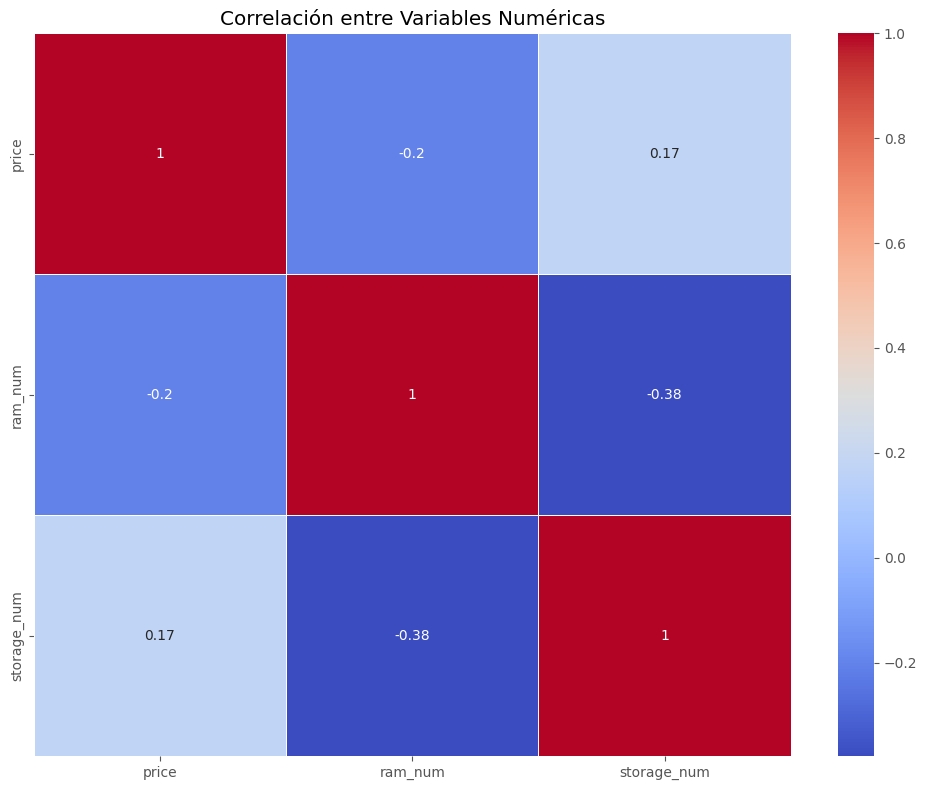

In [ ]:
# 8. Mapa de calor de correlación entre variables numéricas
plt.figure(figsize=(10, 8))
# Crear un DataFrame con solo columnas numéricas
numeric_df = df.select_dtypes(include=['float64', 'int64'])
# Calcular la matriz de correlación
corr_matrix = numeric_df.corr()
# Crear el mapa de calor
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlación entre Variables Numéricas')
plt.tight_layout()
plt.show()
plt.close()